In [9]:
import json

# 1. 读取原始 JSON
with open('lingolift_cleaned.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 2. 构建映射关系：P-0→P-1, P-1→P-2, …, P-9→P-10
mapping = {f'P-{i}': f'P-{i+1}' for i in range(0, 10)}

# 3. 应用映射重命名
for resp in data['responses']:
    old = resp['Code of Teachers']
    resp['Code of Teachers'] = mapping.get(old, old)

# 4. 排序：先按 Weeks，再按编号（去掉“P-”后的数字）
data['responses'].sort(
    key=lambda x: (x['Weeks'], int(x['Code of Teachers'].split('-')[1]))
)

# 5. 保存为新的变量，后面直接使用 lingolift_data 即可
lingolift_data = data

# （可选）写回文件以备检查
with open('lingolift_cleaned_sorted.json', 'w', encoding='utf-8') as f:
    json.dump(lingolift_data, f, ensure_ascii=False, indent=2)


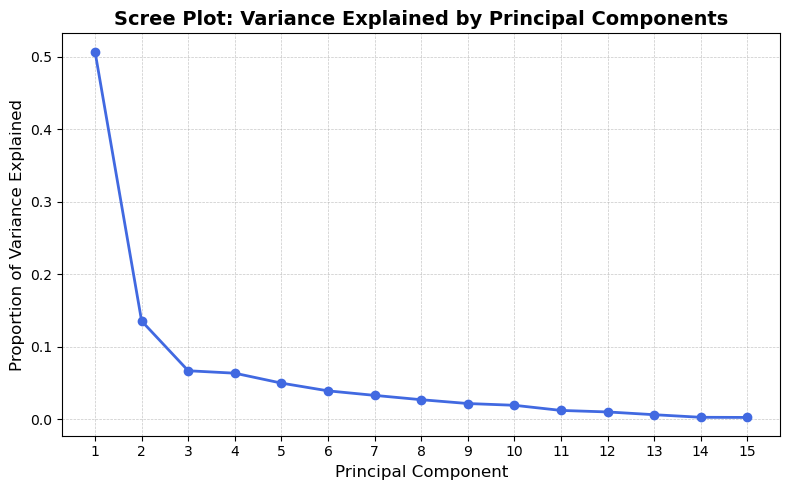

In [28]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# === 1. 载入 JSON 文件 ===
with open("lingolift_transformed.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data["responses"])

# === 2. 选取 Q1–Q16，排除 Q9 ===
q_cols = [col for col in df.columns if col.startswith("Q") and col[1:].isdigit()]
q_cols = [col for col in q_cols if 1 <= int(col[1:]) <= 16 and col != 'Q9']

# 转换为数值型
df[q_cols] = df[q_cols].apply(pd.to_numeric, errors='coerce')

# 去除缺失
df_clean = df[q_cols].dropna()

# === 3. 标准化 & 主成分分析 ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

pca = PCA()
pca.fit(X_scaled)
explained_variance = pca.explained_variance_ratio_

# === 4. 绘制优化版碎石图（Scree Plot） ===
plt.style.use('default')
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white"
})

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1),
         explained_variance,
         marker='o',
         linestyle='-',
         color='royalblue',
         linewidth=2,
         markersize=6)

plt.title("Scree Plot: Variance Explained by Principal Components", fontsize=14, fontweight='bold')
plt.xlabel("Principal Component", fontsize=12)
plt.ylabel("Proportion of Variance Explained", fontsize=12)
plt.xticks(range(1, len(explained_variance)+1), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


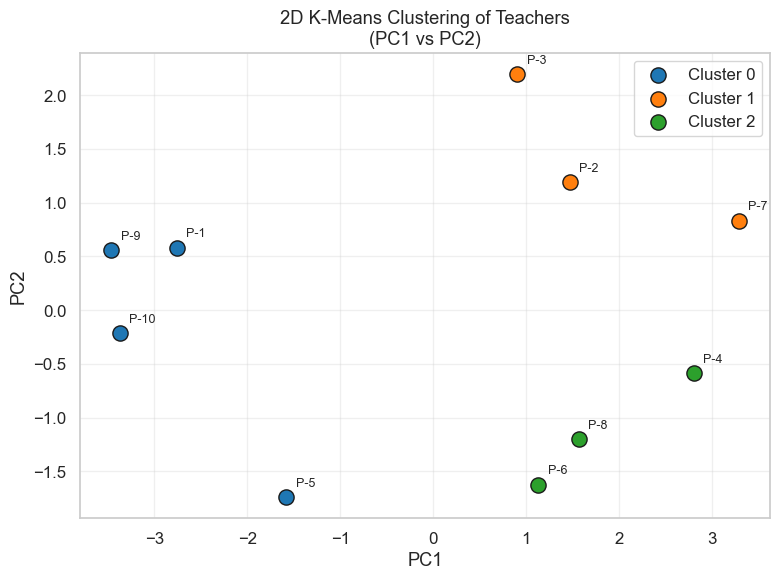

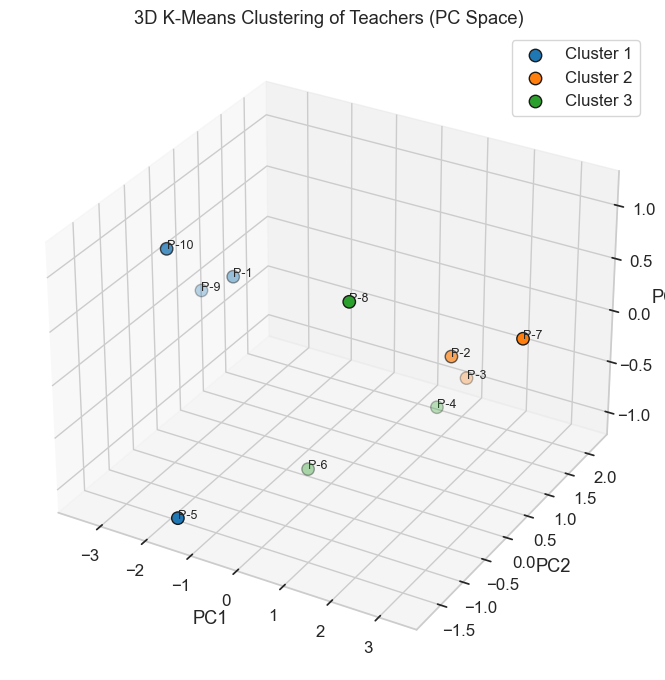

In [4]:
import json
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === 1. 加载 JSON 数据 ===
with open("lingolift_transformed.json", "r", encoding="utf-8") as f:
    data = json.load(f)
df = pd.DataFrame(data["responses"])

# === 2. 选取 Q1–Q16 并排除 Q9 ===
q_cols = [c for c in df.columns if c.startswith("Q") and c[1:].isdigit()]
q_cols = [c for c in q_cols if 1 <= int(c[1:]) <= 16 and c != "Q9"]

# 转换为数值型
df[q_cols] = df[q_cols].apply(pd.to_numeric, errors="coerce")

# === 3. PCA 提取前三主成分 ===
pca = PCA(n_components=3, random_state=42)
pcs = pca.fit_transform(df[q_cols].fillna(df[q_cols].mean()))
df[['PC1','PC2','PC3']] = pcs

# === 4. 聚合到教师层面：对每位教师 3 个 PC 取均值 ===
teacher_pcs = df.groupby("Code of Teachers")[['PC1','PC2','PC3']].mean()

# === 5. K-Means 聚类（三簇） ===
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
teacher_pcs['Cluster'] = kmeans.fit_predict(teacher_pcs[['PC1','PC2','PC3']])

# === 6a. 二维可视化：PC1 vs PC2 ===
plt.figure(figsize=(8,6))
colors = ['#1f77b4','#ff7f0e','#2ca02c']
for cl, grp in teacher_pcs.groupby('Cluster'):
    plt.scatter(grp['PC1'], grp['PC2'], s=120, c=colors[cl], label=f'Cluster {cl}', edgecolor='k')
    for tid, row in grp.iterrows():
        plt.text(row['PC1']+0.1, row['PC2']+0.1, tid, fontsize=9)
plt.title('2D K-Means Clustering of Teachers\n(PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# === 6b. 三维可视化：PC1 vs PC2 vs PC3 ===
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
for cl, grp in teacher_pcs.groupby('Cluster'):
    ax.scatter(grp['PC1'], grp['PC2'], grp['PC3'],
               s=80, c=colors[cl], label=f'Cluster {cl+1}', edgecolor='k')
    for tid, row in grp.iterrows():
        ax.text(row['PC1'], row['PC2'], row['PC3'], tid, size=9)
ax.set_title('3D K-Means Clustering of Teachers (PC Space)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.tight_layout()
plt.show()


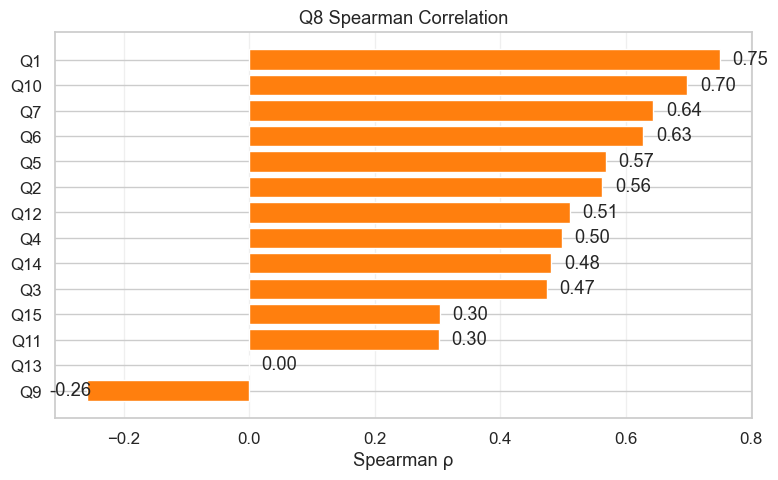

In [35]:
import json
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# ---------- 1. 读取原始 JSON 数据 ----------
with open("lingolift_transformed.json", "r", encoding="utf-8") as f:
    data = json.load(f)
df = pd.DataFrame(data["responses"])

# ---------- 2. 数值处理 ----------
q_cols = [c for c in df.columns if c.startswith("Q") and c[1:].isdigit()]
df[q_cols] = df[q_cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=q_cols)  # 移除有缺失的行


# ---------- 3. Spearman 相关 ----------
def spearman_against(target, exclude=None):
    exclude = exclude or set()
    res = []
    for col in q_cols:
        if col == target or col in exclude:
            continue
        rho, p = stats.spearmanr(df[target], df[col], nan_policy='omit')
        res.append({"Question": col, "rho": rho, "p": p})
    out = pd.DataFrame(res).sort_values("rho", ascending=False).reset_index(drop=True)
    return out

corr_q8 = spearman_against("Q8", exclude={"Q16"})

# ---------- 4. 可视化函数 ----------
def plot_corr(df_corr, title, color="#1f77b4", top_n=15):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.barh(df_corr["Question"].head(top_n),
            df_corr["rho"].head(top_n),
            color=color)
    ax.set_xlabel("Spearman ρ")
    ax.set_title(title)
    ax.invert_yaxis()
    for i, v in enumerate(df_corr["rho"].head(top_n)):
        ax.text(v + 0.02 if v >= 0 else v - 0.06,
                i, f"{v:.2f}", va='center')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---------- 5. 绘图 ----------
plot_corr(corr_q8,
          title="Q8 Spearman Correlation",
          color="#ff7f0e")


In [16]:
import statsmodels.api as sm

# 选用的自变量列
selected_vars = ["Q6", "Q7", "Q1", "Q10"]
X = df[selected_vars]
y = df["Q8"]

# 加入常数项（截距）
X = sm.add_constant(X)

# 拟合线性回归
model = sm.OLS(y, X).fit()

# 打印摘要
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                     Q8   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     12.47
Date:                Sun, 20 Jul 2025   Prob (F-statistic):           1.03e-05
Time:                        09:50:42   Log-Likelihood:                -23.653
No. Observations:                  30   AIC:                             57.31
Df Residuals:                      25   BIC:                             64.31
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4108      0.610      0.674      0.5

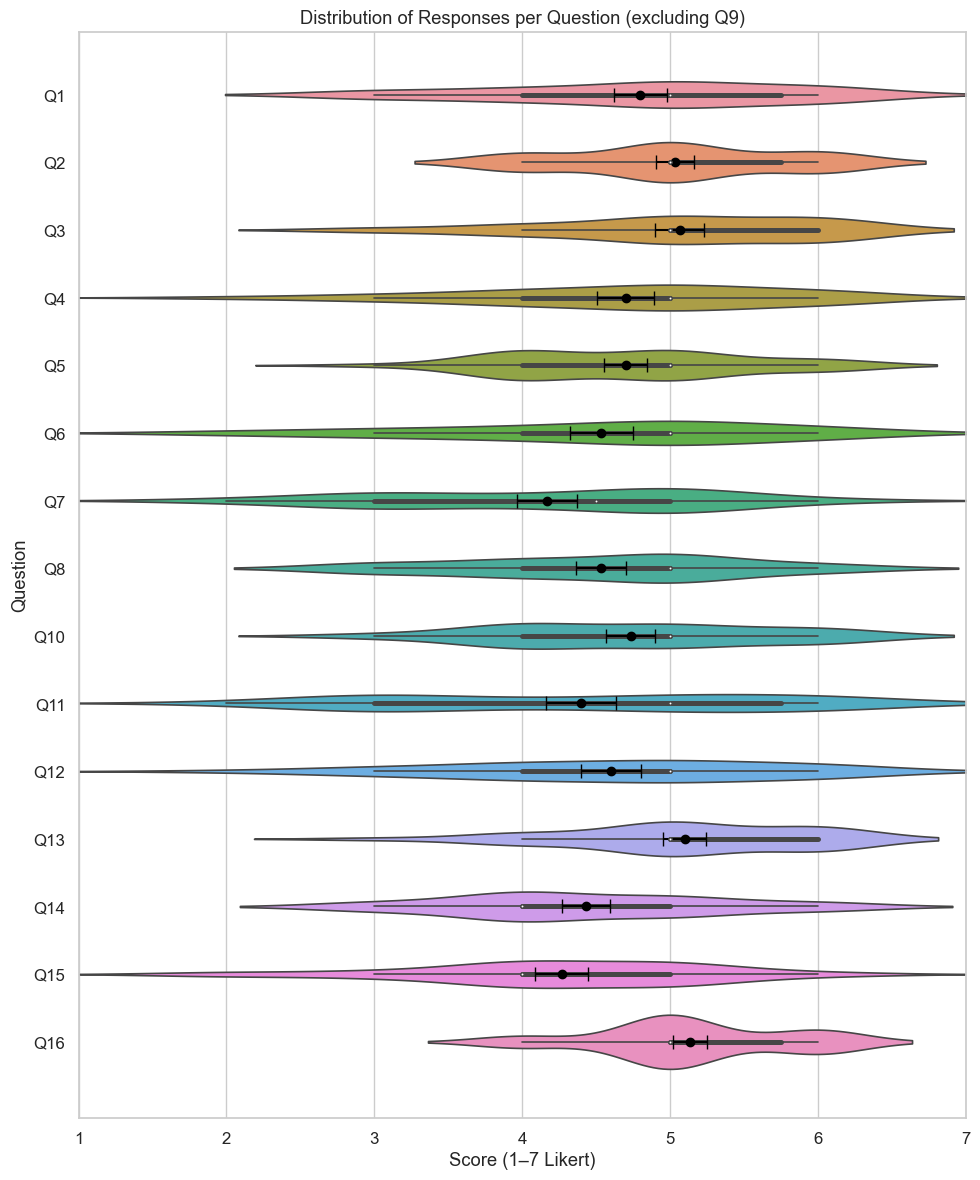

Q9 Friedman test: χ² = 3.100, p = 0.212


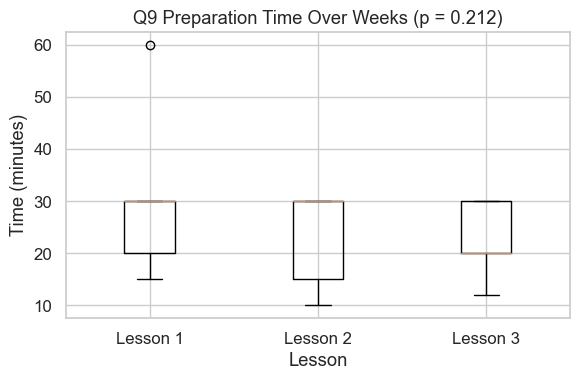

In [3]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import friedmanchisquare

# === 1. Load and preprocess data ===
with open("lingolift_transformed.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data["responses"])

# Convert Q-columns to numeric and drop missing
q_cols = [c for c in df.columns if c.startswith("Q") and c[1:].isdigit()]
df[q_cols] = df[q_cols].apply(pd.to_numeric, errors="coerce")
df_clean = df.dropna(subset=q_cols)

# === 2. Violin plot without Q9 (axis extended to 7) ===
num_questions = [q for q in q_cols if q != 'Q9']

df_long = df_clean.melt(
    value_vars=num_questions,
    var_name="Question",
    value_name="Score"
)

mean_scores = df_clean[num_questions].mean(numeric_only=True)
sem_scores = df_clean[num_questions].std(numeric_only=True) / np.sqrt(len(df_clean))

plt.figure(figsize=(10, 12))
sns.set(style="whitegrid", font_scale=1.1)

ax = sns.violinplot(
    data=df_long,
    y="Question",
    x="Score",
    inner="box",
    linewidth=1.2
)

# Add mean and SEM
for i, question in enumerate(num_questions):
    ax.errorbar(
        mean_scores[question],
        i,
        xerr=sem_scores[question],
        fmt='o',
        color='black',
        capsize=5
    )

ax.set_title("Distribution of Responses per Question (excluding Q9)")
ax.set_xlabel("Score (1–7 Likert)")
ax.set_ylabel("Question")
plt.xlim(1, 7)
plt.tight_layout()
plt.show()

# === 3. Q9 over weeks & Friedman test ===
df_q9 = df_clean.pivot(
    index="Code of Teachers",
    columns="Weeks",
    values="Q9"
)

stat, p = friedmanchisquare(df_q9[1], df_q9[2], df_q9[3])
print(f"Q9 Friedman test: χ² = {stat:.3f}, p = {p:.3f}")

plt.figure(figsize=(6, 4))
plt.boxplot(
    [df_q9[1], df_q9[2], df_q9[3]],
    labels=["Lesson 1", "Lesson 2", "Lesson 3"],
    showfliers=True
)
plt.title(f"Q9 Preparation Time Over Weeks (p = {p:.3f})")
plt.xlabel("Lesson")
plt.ylabel("Time (minutes)")
plt.tight_layout()
plt.show()


In [23]:
import csv
import json

# 读取 CSV 文件头，提取问题映射
questions = {}
with open('sus.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader)
    # 识别题目列: 带 Q 开头列
    question_indices = []
    for idx, header in enumerate(headers):
        if header.startswith('Q'):
            # 拆分问题编号和文本
            parts = header.split(':', 1)
            qid = parts[0].strip()
            qtext = parts[1].strip() if len(parts) > 1 else ''
            questions[qid] = qtext
            question_indices.append((idx, qid))

responses = []

# 读取所有行并构建响应列表
with open('sus.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader)
    for row in reader:
        # 提取教师编号和时间戳
        code = row[headers.index('Teachers Code')]
        timestamp = row[headers.index('Time')]
        # 提取每个题的答案
        answers = []
        for idx, qid in question_indices:
            val = row[idx].strip()
            try:
                answers.append(int(val))
            except ValueError:
                answers.append(None)
        responses.append({
            'code': code,
            'timestamp': timestamp,
            'answers': answers
        })

# 组合并保存为 JSON
output = {
    'questions': questions,
    'responses': responses
}

with open('sus.json', 'w', encoding='utf-8') as jsonfile:
    json.dump(output, jsonfile, ensure_ascii=False, indent=2)

print('已成功将 sus.csv 转换并保存为 sus.json')


已成功将 sus.csv 转换并保存为 sus.json


In [24]:
import json
import re

# 读取已有的 sus.json
with open('sus.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 提取 responses 并按教师编号排序 (P-1, P-2, ..., P-10)
def sort_key(item):
    code = item.get('code', '')
    # 提取数字部分
    match = re.search(r'P-(\d+)', code, re.IGNORECASE)
    return int(match.group(1)) if match else float('inf')

sorted_responses = sorted(data.get('responses', []), key=sort_key)

data['responses'] = sorted_responses

# 将排序后的结果保存回 sus.json
with open('sus.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print('已将 sus.json 中的 responses 按教师编号顺序排序并保存。')


已将 sus.json 中的 responses 按教师编号顺序排序并保存。


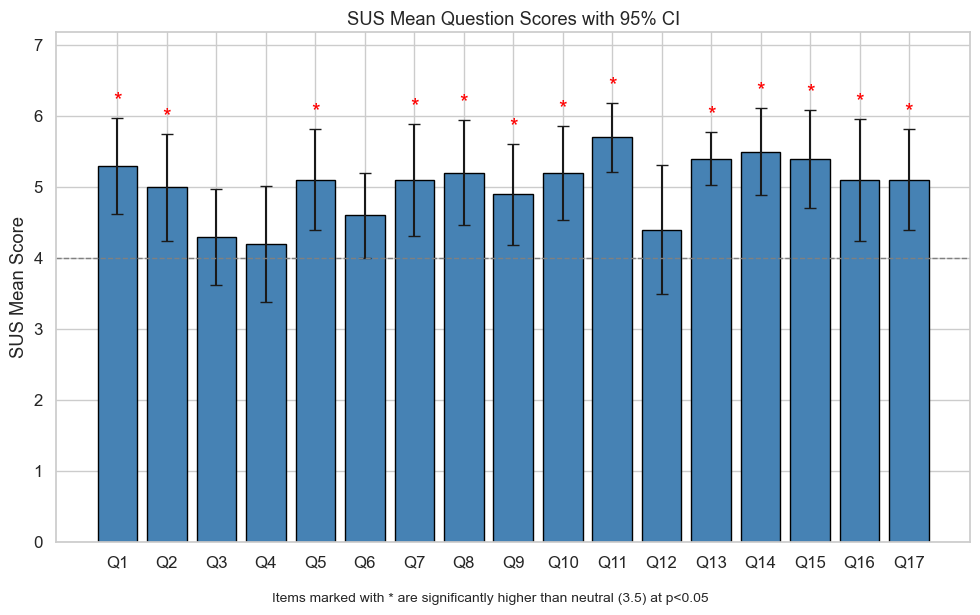

In [36]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# === 1. 读取 SUS 数据 ===
with open("sus.json", "r", encoding="utf-8") as f:
    sus = json.load(f)

# 构建 DataFrame：行=教师、列=Q1–Q17
df = pd.DataFrame([r["answers"] for r in sus["responses"]],
                  columns=[f"Q{i}" for i in range(1, 18)])

# === 2. 计算统计量 ===
means = df.mean()
sem   = df.sem()
ci95  = sem * stats.t.ppf(0.975, df=len(df) - 1)

# 单样本 t 检验 vs 中立 4
pvals = df.apply(lambda col: stats.ttest_1samp(col, 4, nan_policy='omit').pvalue)

# === 3. 绘制条形图并标星 ===
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    means.index, means.values,
    yerr=ci95.values, capsize=4,
    color="steelblue", edgecolor="black"
)

# 中立线
ax.axhline(4, color="gray", linestyle="--", linewidth=1)

# 标注星号
for i, (bar, p) in enumerate(zip(bars, pvals)):
    if p < 0.05:
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + ci95.iloc[i] + 0.1,
            "*", ha="center", va="bottom",
            fontsize=16, color="red"
        )

# 坐标与标题
ax.set_ylabel("SUS Mean Score")
ax.set_title("SUS Mean Question Scores with 95% CI")

# === 4. 添加图注 ===
plt.figtext(
    0.5, -0.02,
    "Items marked with * are significantly higher than neutral (3.5) at p<0.05",
    ha="center", fontsize=10
)

# 完成绘图
ax.set_ylim(0, (means + ci95).max() + 1)
plt.tight_layout()
plt.show()


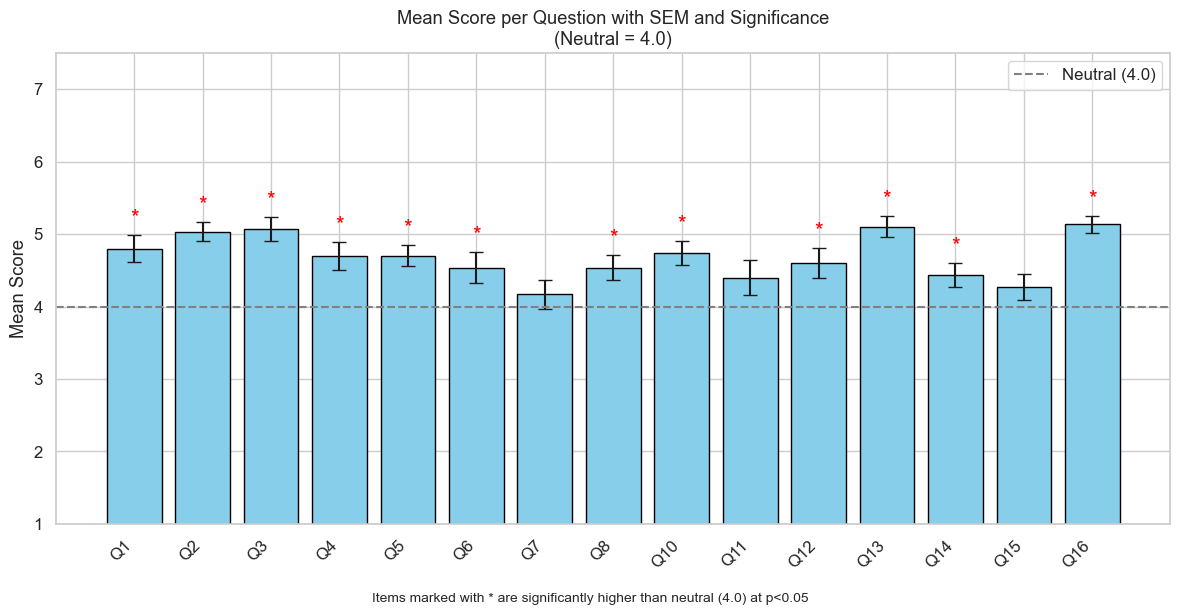

In [37]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

# === 1. 读取并预处理数据 ===
with open("lingolift_transformed.json", "r", encoding="utf-8") as f:
    data = json.load(f)
df = pd.DataFrame(data["responses"])

# 将 Q 列转换为数值，剔除含缺失值的行
q_cols = [c for c in df.columns if c.startswith("Q") and c[1:].isdigit()]
df[q_cols] = df[q_cols].apply(pd.to_numeric, errors="coerce")
df_clean = df.dropna(subset=q_cols)

# === 2. 计算均值、SEM 和 p 值（vs 中立 4.0） ===
questions = [q for q in q_cols if q != 'Q9']
mean_scores = df_clean[questions].mean()
sem_scores  = df_clean[questions].std() / np.sqrt(df_clean.shape[0])

# 针对每道题做单样本 t 检验 vs 中立值 4.0
p_values = {}
for q in questions:
    _, p = ttest_1samp(df_clean[q], 4.0, nan_policy='omit')
    p_values[q] = p

# === 3. 绘制带星号的条形图 ===
plt.figure(figsize=(12, 6))
bars = plt.bar(
    range(len(questions)),
    mean_scores.values,
    yerr=sem_scores.values,
    capsize=5,
    color='skyblue',
    edgecolor='black'
)

# 中立线 (midpoint of 1–7 scale)
plt.axhline(4.0, linestyle='--', color='gray', label='Neutral (4.0)')

# 在显著的柱子上方标星
for i, q in enumerate(questions):
    if p_values[q] < 0.05:
        height = mean_scores[q] + sem_scores[q] + 0.1
        plt.text(i, height, '*', ha='center', va='bottom', fontsize=16, color='red')

# 坐标和标题
plt.xticks(range(len(questions)), questions, rotation=45, ha='right')
plt.ylim(1, 7.5)
plt.ylabel('Mean Score')
plt.title('Mean Score per Question with SEM and Significance\n(Neutral = 4.0)')

# 添加图注
plt.figtext(
    0.5, -0.02,
    "Items marked with * are significantly higher than neutral (4.0) at p<0.05",
    ha="center", fontsize=10
)

plt.legend()
plt.tight_layout()
plt.show()
